<a href="https://colab.research.google.com/github/jnsbrdbr/RNN-play-music/blob/master/%20RNN-play-music/RNN_play_music/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#PyFluidSynth is a Python binding for the FluidSynth software synthesizer.
#It allows to use the FluidSynth library in Python code,
#providing a way to play MIDI files and generate sounds from MIDI data.
!pip install --upgrade pyfluidsynth

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install pretty_midi 
#Pretty_midi is a Python library for handling MIDI data, allowing to easily read, write, and modify MIDI files.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!sudo apt install -y fluidsynth

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fluidsynth is already the newest version (2.1.1-2).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


In [4]:
import collections #collections is a built-in module that provides a collection of specialized container data types, in addition to the built-in data types such as lists, dictionaries, and tuples.
import datetime #is a module that provides classes for working with dates and times. 
import fluidsynth #In Python, fluidsynth is a module that provides a Python wrapper for the FluidSynth software synthesizer. FluidSynth is an open-source software synthesizer that can be used to generate sound from MIDI files or other sources.
import glob #In Python, glob is a module that provides a function for working with filenames and directories using pattern matching rules similar to those used in Unix shell. The glob function can be used to search for files or directories that match a specified pattern.
import numpy as np
import pathlib #In Python, pathlib is a module that provides an object-oriented interface for working with file system paths. It allows you to create, manipulate, and inspect paths in a platform-independent way.
import pandas as pd
import pretty_midi#pretty_midi is a Python library for handling MIDI files in a simple and intuitive way. It provides a high-level interface for manipulating MIDI data, such as notes, velocities, and timings, as well as lower-level access to MIDI events such as control changes and program changes.
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000


In [7]:
data_dir = pathlib.Path('/content/data/maestro-v2.0.0')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'maestro-v2.0.0-midi.zip',
      origin='https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )


In [8]:
#The dataset contains about 1,200 MIDI files.
filenames = glob.glob(str(data_dir/'**/*.mid*'))
print('Number of files:', len(filenames))

Number of files: 1282


In [9]:
#download the file
from google.colab import files

In [10]:
sample_file = filenames[4]
files.download(sample_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [11]:
#create the widget
pm = pretty_midi.PrettyMIDI(sample_file)

In [12]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)


In [13]:
display_audio(pm)

#about the data

In [14]:
#what instrment do they use?
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)


Number of instruments: 1
Instrument name: Acoustic Grand Piano


In [15]:
#extract note
#three variables to represent a note when training the model:
#pitch, step and duration.
#The pitch is the perceptual quality of the sound as a MIDI note number.
#The step is the time elapsed from the previous note or start of the track.
#The duration is how long the note will be playing in seconds and is the difference between the note end and note start times. 
for i, note in enumerate(instrument.notes[:10]):
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}')


0: pitch=79, note_name=G5, duration=0.3047
1: pitch=74, note_name=D5, duration=0.0977
2: pitch=71, note_name=B4, duration=0.0807
3: pitch=67, note_name=G4, duration=0.0482
4: pitch=74, note_name=D5, duration=0.0508
5: pitch=72, note_name=C5, duration=0.2227
6: pitch=69, note_name=A4, duration=0.0521
7: pitch=62, note_name=D4, duration=0.0547
8: pitch=72, note_name=C5, duration=0.0521
9: pitch=71, note_name=B4, duration=0.2201


In [16]:
#Extract the notes from the sample MIDI file.
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})


In [17]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head()


,pitch,start,end,step,duration
0,79,1.052083,1.356771,0.000000,0.304688
1,74,1.326823,1.424479,0.274740,0.097656
2,71,1.403646,1.484375,0.076823,0.080729
3,67,1.506510,1.554688,0.102865,0.048177
4,74,1.735677,1.786458,0.229167,0.050781


In [18]:
#It may be easier to interpret the note names rather than the pitches,
#so you can use the function below to convert from the numeric pitch values to note names.
#The note name shows the type of note, accidental and octave number (e.g. C#4).

#train-dataset 

In [19]:
#This code reads in MIDI files specified in a list of file names filenames,
#converts them to a pandas DataFrame of notes using the midi_to_notes function,
#and then concatenates all the resulting DataFrames into a single DataFrame all_notes.

num_files = 50
all_notes = []
for f in filenames[:num_files]:
  notes = midi_to_notes(f)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)


In [20]:
n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)


Number of notes parsed: 380351


In [21]:
#create a tf.data.Dataset from the parsed notes.

In [22]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)


In [23]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec


TensorSpec(shape=(3,), dtype=tf.float64, name=None)


This code takes a bunch of notes and turns them into a special type of list that a computer can use to learn how to make music. The list is made up of smaller lists called "sequences", which are like little music phrases.

The computer needs to learn how to make music by looking at lots of these little sequences, so the code breaks up the big list of notes into lots of smaller sequences. It does this by taking one sequence, moving it over a little bit, and then taking another sequence. It keeps doing this until it has lots of different sequences.

Once it has all these sequences, the computer needs to know which notes come next after each sequence. This is where the labels come in. The labels are like little tags that tell the computer which notes come after each sequence. The code takes each sequence and adds a label that tells the computer which notes come next.

The code also makes sure the notes are all the same size and are in a format the computer can understand. This makes it easier for the computer to learn from them.

Finally, the code gives the computer all these little sequences with their labels, so it can start learning how to make music!

In [24]:
#train the model on batches of sequences of notes.
#Each example will consist of a sequence of notes as the input features,
#and the next note as the label.
#In this way, the model will be trained to predict the next note in a sequence. 
def create_sequences(
    dataset: tf.data.Dataset, 
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)

  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)


In [25]:
seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec


(TensorSpec(shape=(25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

In [26]:
#The shape of the dataset is (100,1), meaning that the model will take 100 notes as input,
#and learn to predict the following note as output.

In [27]:
#this code is useful for understanding the
#format and structure of the data in the seq_ds dataset,
#and for verifying that the data is being loaded correctly.
for seq, target in seq_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 10):', seq[0: 10])
  print()
  print('target:', target)


sequence shape: (25, 3)
sequence elements (first 10): tf.Tensor(
[[0.390625   0.         0.5625    ]
 [0.296875   0.02734375 0.48828125]
 [0.3828125  0.35546875 0.36979167]
 [0.2890625  0.01822917 0.359375  ]
 [0.421875   0.25260417 0.390625  ]
 [0.328125   0.02083333 0.34765625]
 [0.3203125  0.34114583 0.76822917]
 [0.4140625  0.0078125  0.74869792]
 [0.390625   2.26171875 0.53255208]
 [0.296875   0.01692708 0.44921875]], shape=(10, 3), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=41.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.018229166666666963>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.46614583333333215>}


In [28]:
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))


In [29]:
train_ds.element_spec

(TensorSpec(shape=(64, 25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

In [30]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)


In [31]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 25, 3)]      0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 128)          67584       ['input_1[0][0]']                
                                                                                                  
 duration (Dense)               (None, 1)            129         ['lstm[0][0]']                   
                                                                                                  
 pitch (Dense)                  (None, 128)          16512       ['lstm[0][0]']                   
                                                                                              

In [32]:
losses = model.evaluate(train_ds, return_dict=True)
losses

5942/5942 [==============================] - 202s 24ms/step - loss: 5.1245 - duration_loss: 0.2042 - pitch_loss: 4.8462 - step_loss: 0.0741


{'loss': 5.124486446380615,
 'duration_loss': 0.20416101813316345,
 'pitch_loss': 4.846238613128662,
 'step_loss': 0.07408389449119568}

In [33]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)


In [34]:
model.evaluate(train_ds, return_dict=True)


5942/5942 [==============================] - 148s 25ms/step - loss: 0.5206 - duration_loss: 0.2042 - pitch_loss: 4.8462 - step_loss: 0.0741


{'loss': 0.5205561518669128,
 'duration_loss': 0.20416101813316345,
 'pitch_loss': 4.846238613128662,
 'step_loss': 0.07408389449119568}

In [35]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]


In [36]:
%%time
epochs = 50

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)


Epoch 1/50
5942/5942 [==============================] - 342s 57ms/step - loss: 0.3613 - duration_loss: 0.1060 - pitch_loss: 3.9398 - step_loss: 0.0583
Epoch 2/50
5942/5942 [==============================] - 336s 56ms/step - loss: 0.3518 - duration_loss: 0.1026 - pitch_loss: 3.8613 - step_loss: 0.0561
Epoch 3/50
5942/5942 [==============================] - 337s 57ms/step - loss: 0.3460 - duration_loss: 0.1009 - pitch_loss: 3.8004 - step_loss: 0.0551
Epoch 4/50
5942/5942 [==============================] - 326s 55ms/step - loss: 0.3416 - duration_loss: 0.0991 - pitch_loss: 3.7693 - step_loss: 0.0541
Epoch 5/50
5942/5942 [==============================] - 304s 51ms/step - loss: 0.3385 - duration_loss: 0.0977 - pitch_loss: 3.7481 - step_loss: 0.0534
Epoch 6/50
5942/5942 [==============================] - 302s 51ms/step - loss: 0.3362 - duration_loss: 0.0967 - pitch_loss: 3.7272 - step_loss: 0.0531
Epoch 7/50
5942/5942 [==============================] - 301s 51ms/step - loss: 0.3352 - durati

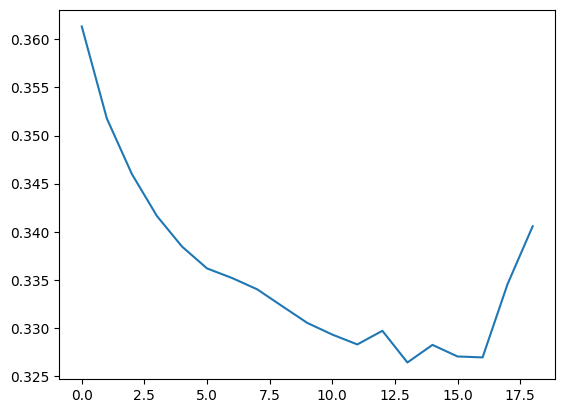

In [37]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()


In [ ]:
def predict_next_note(
    notes: np.ndarray, 
    keras_model: tf.keras.Model, 
    temperature: float = 1.0) -> int:
  """Generates a note IDs using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']

  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)


In [39]:
temperature = 2.0
num_predictions = 120

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))


1/1 [==============================] - 0s 29ms/step


In [ ]:
generated_notes.head(10)

In [41]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str, 
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm


In [42]:

out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)
